# Plane Fit

We are going to present some common methods to find the [plane equation](https://en.wikipedia.org/wiki/Plane_(geometry) given set of 3D points.

## Plane description

We are going to use the *point-normal* form where we have a point on the plane and the normal vector which is orthogonal to the plane:  $\mathbf{n}\cdot\left(\mathbf{r}-\mathbf{r}_0\right)=0$

$\mathbf{r}_0$ is a vector from the origin to some point on the plane $P_0=(x_0, y_0, z_0)$  ,  $\mathbf{n}=(a,b,c)$ some nonzero vector and $\mathbf{r}$ is a vector from the origin to some point $P$ on the plane. This  defines the plane as all the points $\mathbf{r}$ which satisfy thie equation.

Exapnding this vector equation will give us:
$a\left(x-x_0\right)+b\left(y-y_0\right)+c\left(z-z_0\right)=0$

Which is the simple *point-normal* form: $ax+by+cz+d=0$  with  $d=-(ax_0+by_0+cz_0)$

## Generating some data

First we just do some basic imports and initialize some 3D points using a normal unit vector $\mathbf{\hat{n}}=(\frac{1}{\sqrt{2}}, \frac{1}{2}, -\frac{1}{2})$. `data` is $N\times3$ matrix, where $N$ is the number of points and the 3 columns are $x, y, z$. We also create some noisy data by adding normal distributed noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
%matplotlib inline
#%matplotlib notebook

In [2]:
# Generating test data
P0 = np.array([0.0, 0.0, 0.0])
a, b, c, d = 0.707, 0.5, -0.5, 2
X = (np.random.random(100) - 0.5) * 2
Y = (np.random.random(100) - 0.5) * 2
Z = (a*X + b*Y + d) / (-c)
data = np.vstack((X, Y, Z)).T 
data += np.random.normal(0, 0.2, data.shape)

## Least Squares
The first method we are going to use is [linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics). Here we are going to represent our plane equation as: $z = ax + by + d$, by setting $c=-1$ and we want to find the best parameters $a, b$ and $d$ given our points. Of course, for any number of points larger than 3 this is an [overdetermined system](https://en.wikipedia.org/wiki/Overdetermined_system) of equations and the least squares method will find the best parameters which minimizes the sum of squared differences between our points and the plane.

Using matrix notation:  $\mathbf{Ax}=\mathbf{b}$  , where $\mathbf{A}_{N\times 3}=\left[ \begin{array}{ccc}
x_0 & y_0 & 1 \\
x_1 & y_1 & 1 \\
\vdots & \vdots & \vdots \\
x_N & y_N & 1 \end{array} \right]$ ,  $\mathbf{x}_{3\times 1}=\left[a, b, d\right]^T$  and  $\mathbf{b}_{N\times 1}=\left[\ \begin{array}{c} z_0 \\ z_1 \\ \vdots \\ z_N \end{array} \right]$

### Remarks
- Notice that $\mathbf{x}$ here just represents our unknown, which is the parameters $(a,b,d)$. Nothing to do with the x-axis.
- Common mistake is to represent our problem as homegenous using the standard equation: $ax+by+cz+d=0$ with
$\mathbf{A}_{N\times 4}=\left[ \begin{array}{cccc}
x_0 & y_0 & z_0 & 1 \\
x_1 & y_1 & z_1 & 1 \\
\vdots & \vdots & \vdots & \vdots \\
x_N & y_N & z_N & 1 \end{array} \right]$ ,  $\mathbf{x}_{4\times 1}=\left[a, b, c, d\right]^T$  and  $\mathbf{b}_{N\times 1}=\mathbf{0}$ .  In this case the least-squares would have just given us the trivial solution where $\mathbf{x}=\mathbf{0}$

In [3]:
# Least-squares
A = np.vstack((data[:,0], data[:,1], np.ones(data.shape[0]))).T
C,_,_,_ = np.linalg.lstsq(A, data[:,2])    # coefficients
print("Estimated coefficients (Least-squares):", end="")
print("a=%.3f, b=%.3f, c=-1, d=%.3f" % tuple(C))

# regular grid covering the domain of the data
XX, YY = np.meshgrid(np.arange(-2, 2, 0.5), np.arange(-2, 2, 0.5))

# evaluate it on grid
ZZ = C[0]*XX + C[1]*YY + C[2]

# Get the normal unit vector
n = np.array([C[0], C[1], -1.0])
n /= np.linalg.norm(n)
print("n_hat=(%.3f, %.3f, %.3f)" % tuple(n))

# Get point on the plane
i = int(XX.shape[0] / 2)
p0 = np.array([XX[i, i], YY[i, i], ZZ[i, i]])

Estimated coefficients (Least-squares):a=1.347, b=0.862, c=-1, d=3.997
n_hat=(0.714, 0.457, -0.530)


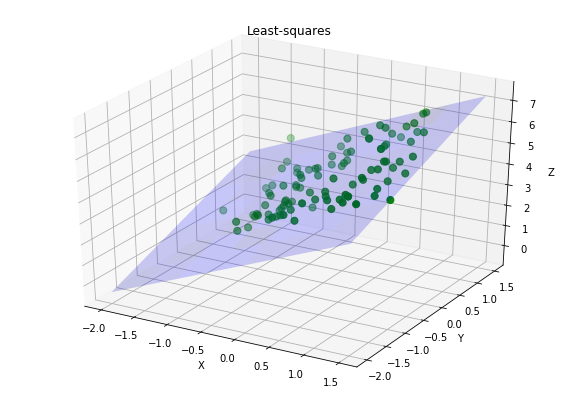

In [4]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], color='green', s=50)
#ax.plot([p0[0], p0[0]+n[0]], [p0[1], p0[1]+n[1]], [p0[2], p0[2]+n[2]], color='blue', marker='.')
# ax.quiver(p0[0], p0[1], p0[2], -n[0], -n[1], -n[2], length=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Least-squares")
ax.axis('equal')
ax.axis('tight');

## RANSAC

In [5]:
from sklearn import linear_model

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
model_ransac.fit(A, data[:, 2])
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print("Estimated coefficients (RANSAC):", end="")
print("a=%.3f, b=%.3f, c=-1, d=%.3f" % tuple(model_ransac.estimator_.coef_))

# Evaluate on grid
ZZ = C[0]*XX + C[1]*YY + C[2]

Estimated coefficients (RANSAC):a=1.459, b=0.869, c=-1, d=4.040


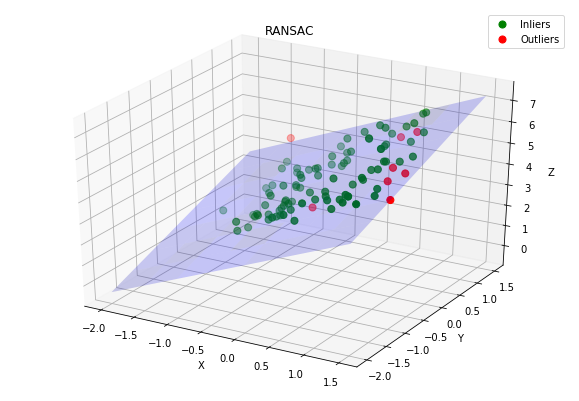

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(data[inlier_mask, 0], data[inlier_mask, 1], data[inlier_mask, 2], color='green', s=50, label='Inliers')
ax.scatter(data[outlier_mask, 0], data[outlier_mask, 1], data[outlier_mask, 2], color='red', s=50, label='Outliers')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("RANSAC")
ax.legend()
ax.axis('equal')
ax.axis('tight');

## SVD

In [7]:
# Set up constraint equations of the form  Ax = 0,
# where x is a column vector of the plane coefficients
# in the form x[0]*X + x[1]*Y +x[2]*Z = 0.
centeroid = data.mean(axis=0)
M = data - centeroid
[u, s, vh] = np.linalg.svd(M)

# The last column of the V matrix (last row of Vh matrix) indicate the eigenvectors of
# smallest eigenvalues (singular values).
v = vh.conj().transpose()  
n = v[:,-1]

# Set c=-1
n /= -n[2]

# Compute d
d = -data[0, :].dot(n)

print("Estimated coefficients (SVD):", end="")
print("a=%.3f, b=%.3f, c=%.3f, d=%.3f" % tuple(n.tolist() + [d]))

# Evaluate on grid
ZZ = n[0]*XX + n[1]*YY + d

Estimated coefficients (SVD):a=1.488, b=0.945, c=-1.000, d=4.184


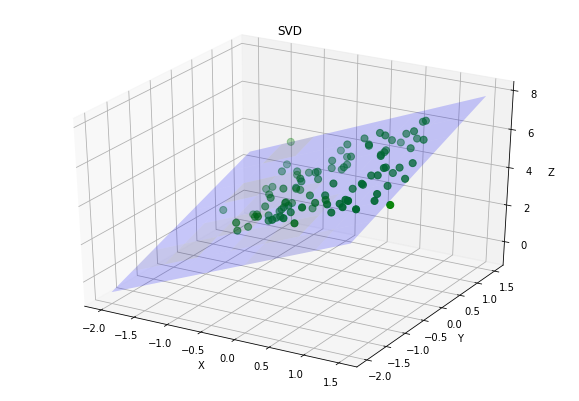

In [8]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], color='green', s=50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("SVD")
ax.axis('equal')
ax.axis('tight');